c:\Users\Kristofer\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Сравнение параметров p, d, q:
    p  d  q       MSE
14  2  0  2  2.849747
13  2  0  1  2.850416
7   1  0  1  2.855176
8   1  0  2  2.858200
12  2  0  0  2.859477
6   1  0  0  2.860876
2   0  0  2  2.862615
0   0  0  0  2.862672
1   0  0  1  2.862679
3   0  1  0  3.311662
10  1  1  1  3.397811
5   0  1  2  3.401086
11  1  1  2  3.419765
17  2  1  2  3.433748
16  2  1  1  3.447675
4   0  1  1  3.454791
9   1  1  0  3.482672
15  2  1  0  3.522219

Лучшие параметры ARIMA: (2, 0, 2) с MSE: 2.8497467986


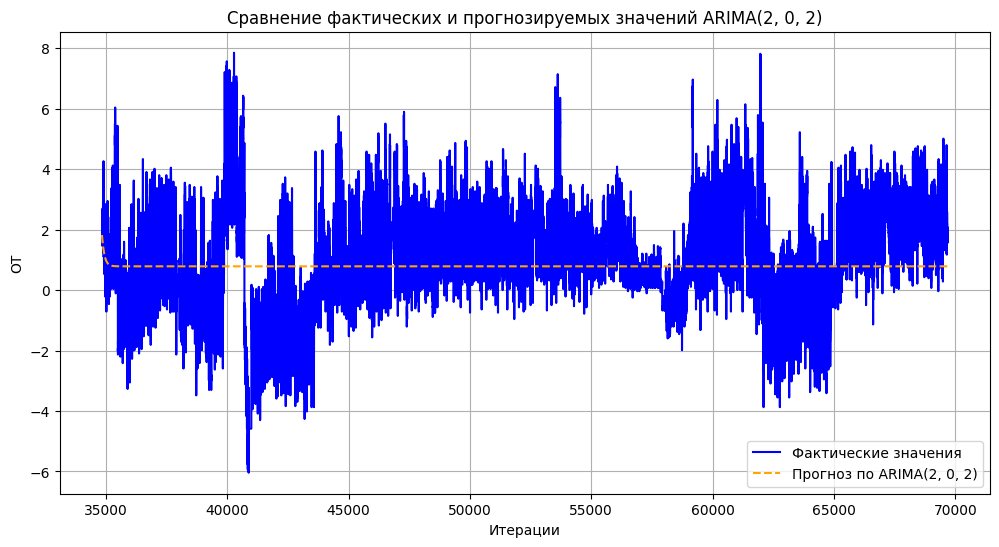


--- Итеративное предсказание с использованием экспоненциального сглаживания ---
Ошибка MSE для итеративного метода: 0.2516677202


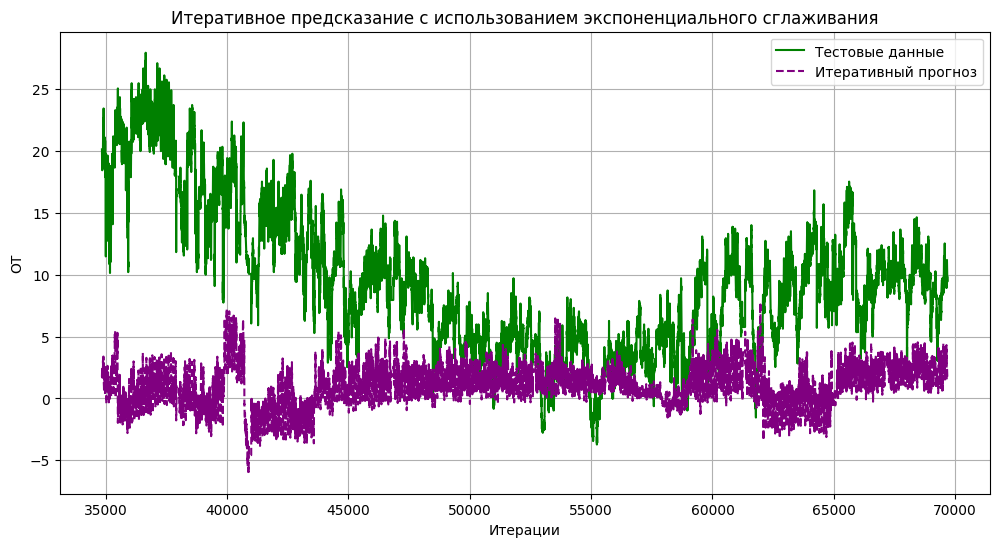


--- Сравнение методов ---
MSE для лучшей модели ARIMA: 2.8497467986
MSE для итеративного метода: 0.2516677202


In [47]:
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу "экспоненциальное среднее".

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Загрузка данных
df = pd.read_csv('ETTm1.csv')
x = df.OT  # Используем столбец OT как временной ряд

# Параметры разделения данных
N = 2  # Количество групп
groups = np.array_split(df, N)
train, test = groups[0], groups[1]
train_values = train['MULL']
test_values = test['MULL']

def change_params(train_values, test_values):
    #Функция для поиска оптимальных параметров ARIMA
    results = []
    best_mse = float('inf')
    best_order = None
    best_model = None

    for p in range(3):
        for d in range(2):
            for q in range(3):
                try:
                    model = ARIMA(train_values, order=(p, d, q))
                    fitted_model = model.fit()
                    
                    predictions = fitted_model.forecast(steps=len(test_values))
                    
                    mse = mean_squared_error(test_values, predictions)
                    results.append({'p': p, 'd': d, 'q': q, 'MSE': mse})
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception:
                    continue

    results_df = pd.DataFrame(results).sort_values(by='MSE')
    return best_model, best_order, best_mse, results_df

# Выполнение перебора и нахождение лучших параметров
best_model, best_order, best_mse, results_df = change_params(train_values, test_values)

# Печать сравнений параметров
print("Сравнение параметров p, d, q:")
print(results_df)

# Печать лучших параметров и ошибки
print(f"\nЛучшие параметры ARIMA: {best_order} с MSE: {best_mse:.10f}")

# Прогнозирование на основе лучших параметров
predictions_best = best_model.forecast(steps=len(test_values))

# Создание общего индекса для визуализации
test_index = np.arange(len(test_values), len(test_values) + len(test_values))

# Визуализация результатов ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_index, test_values.values, label='Фактические значения', color='blue')
plt.plot(test_index, predictions_best, label=f'Прогноз по ARIMA{best_order}', color='orange', linestyle='--')
plt.legend()
plt.title(f'Сравнение фактических и прогнозируемых значений ARIMA{best_order}')
plt.xlabel('Итерации')
plt.ylabel('OT')
plt.grid(True)
plt.show()

# Итеративное предсказание с экспоненциальным сглаживанием
print("\n--- Итеративное предсказание с использованием экспоненциального сглаживания ---")
alpha = 0.5  # Коэффициент экспоненциального сглаживания
x_iter_train = train_values.values
x_iter_test = test_values.values
x_iter_predictions = []

# Итеративное обновление прогноза
for i in range(len(x_iter_test)):
    if i == 0:
        forecast = x_iter_train[-1]
    else:
        forecast = alpha * x_iter_test[i-1] + (1 - alpha) * forecast
    x_iter_predictions.append(forecast)

# Оценка итеративного метода (MSE)
mse_iter = mean_squared_error(x_iter_test, x_iter_predictions)
print(f"Ошибка MSE для итеративного метода: {mse_iter:.10f}")

# Визуализация итеративного метода
plt.figure(figsize=(12, 6))
plt.plot(test_index, x_test.values, label='Тестовые данные', color='green')
plt.plot(test_index, x_iter_predictions, label='Итеративный прогноз', color='purple', linestyle='--')
plt.title('Итеративное предсказание с использованием экспоненциального сглаживания')
plt.xlabel('Итерации')
plt.ylabel('OT')
plt.legend()
plt.grid(True)
plt.show()

# Сравнение MSE обоих методов
print("\n--- Сравнение методов ---")
print(f"MSE для лучшей модели ARIMA: {best_mse:.10f}")
print(f"MSE для итеративного метода: {mse_iter:.10f}")